# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
%matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from kooplearn.data import TrajectoryContextDataset, TensorContextDataset

# Import dependencies
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs

In [3]:
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks

In [4]:
import ml_confs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks

In [5]:
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [6]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-07-04 21:14:19,335 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


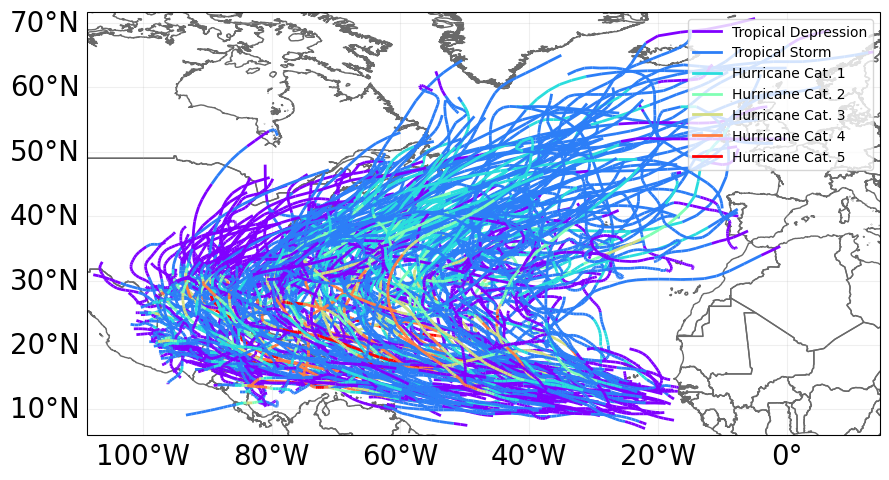

In [7]:
ax = tc_tracks.plot()

### Data standardisation

An important pre-processing step is data standardisation. This step rescales the data to zero mean and unit variance, a regime where most of the common machine learning tools are targeted at. Also, data standardisation allows for better comparability between prediction performance on different datasets.

In [8]:
from sklearn.preprocessing import StandardScaler

data = np.stack(
    [np.random.uniform(0,12,size=100), np.random.uniform(-12,3,size=100), np.random.uniform(2,6,size=100)],
    axis = 1
)

scaler = StandardScaler()

In [9]:
np.mean(data[:,0]), np.mean(data[:,1]), np.mean(data[:,2]), np.var(data[:,0]), np.var(data[:,1]), np.var(data[:,2])

(5.6520792607380335,
 -4.519754525896803,
 4.066745767794378,
 12.859621319361203,
 16.533157863501224,
 1.2790942192893746)

In [10]:
_ = scaler.fit(data)
data_trafo = scaler.transform(data)

In [11]:
np.mean(data_trafo[:,0]), np.mean(data_trafo[:,1]), np.mean(data_trafo[:,2]), np.var(data_trafo[:,0]), np.var(data_trafo[:,1]), np.var(data_trafo[:,2])

(3.7914116290949096e-16,
 9.547918011776346e-17,
 2.2715163083830704e-15,
 0.9999999999999999,
 0.9999999999999994,
 0.9999999999999999)

Looks good.

Now we apply the data scaling to our TCTracks data.

In [12]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

C:\Users\Eric\AppData\Local\Temp\ipykernel_2092\211683374.py:6: UserWarning: Data entry 1 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_2092\211683374.py:6: UserWarning: Data entry 2 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_2092\211683374.py:6: UserWarning: Data entry 3 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_2092\211683374.py:6: UserWarning: Data entry 4 has been removed since it is shorter than the 
                context_length.
  tensor_context_train = context_dataset_from_TCTracks(
C:\Users\Eric\AppData\Local\Temp\ipykernel_2092\211683374.py:6: UserWarning: Data entry 8 has been r

In [13]:
tensor_context_train.data.shape

(8096, 42, 2)

In [14]:
def standardize_TensorContextDataset(tensor_context: TensorContextDataset, scaler, fit: bool = True, backend: str = "auto", **backend_kw)->TensorContextDataset:
    if fit:
        data_transformed = scaler.fit_transform(tensor_context.data.reshape((tensor_context.shape[0], tensor_context.shape[1]*tensor_context.shape[2]))).reshape(tensor_context.shape)
    else:
        data_transformed = scaler.transform(tensor_context.data.reshape((tensor_context.shape[0], tensor_context.shape[1]*tensor_context.shape[2]))).reshape(tensor_context.shape)
    tensor_context_transformed = TensorContextDataset(
        data_transformed, backend, **backend_kw
    )
    return tensor_context_transformed

In [15]:
scaler = StandardScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

### Train and compare kernel models

In [16]:
contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

In [17]:
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (8096, 42, 2): 8096 contexts of length 42 with 2 features each
Test contexts have shape (1003, 42, 2): 1003 contexts of length 42 with 2 features each


### Train and compare kernel models

In [18]:
# Wrapper function useful for measuring the execution time of functions
# Adapted from https://realpython.com/python-timer/#creating-a-python-timer-decorator
from time import perf_counter

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        toc = perf_counter()
        elapsed_time = toc - tic
        return value, elapsed_time

    return wrapper_timer

In [19]:
contexts['train'].shape

(8096, 42, 2)

In [20]:
def runner(models, stop):
    results = {}
    for name, model in models.items():
        model, fit_time = timer(model.fit)(contexts['train'][:stop])
        # One-step prediction
        X_pred_test = model.predict(contexts['train'])
        X_true_test = contexts['train'].lookforward(model.lookback_len)

        results[name] = {
            'fit_time': fit_time,
            'RMSE_onestep_test': np.sqrt(np.mean((X_pred_test - X_true_test)**2)),
        }
        print(r'Fitting of {} model took {:.2f}s and has a test RMSE of {:.5f}.'.format(name, results[name]['fit_time'], results[name]['RMSE_onestep_test']))
    return results

In [21]:
train_stops = np.logspace(2.5, 2.9, 5).astype(int)
# train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([316, 398, 501, 630, 794])

In [22]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [23]:
results = []
for stop in train_stops:
    models = {
        # 'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
        'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
        'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
    }
    print(f'\nTraining points: {stop}')
    results.append(runner(models, stop))


Training points: 316


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


Fitting of Randomized-RRR model took 0.16s and has a test RMSE of 0.06058.
Fitting of Nystroem-RRR model took 0.15s and has a test RMSE of 0.08892.

Training points: 398
Fitting of Randomized-RRR model took 0.04s and has a test RMSE of 0.04961.


The rank attribute has been updated to 19.
Consider decreasing the rank parameter.


Fitting of Nystroem-RRR model took 0.52s and has a test RMSE of 0.07660.

Training points: 501
Fitting of Randomized-RRR model took 0.06s and has a test RMSE of 0.04436.


The rank attribute has been updated to 22.
Consider decreasing the rank parameter.


Fitting of Nystroem-RRR model took 0.38s and has a test RMSE of 0.07529.

Training points: 630
Fitting of Randomized-RRR model took 0.06s and has a test RMSE of 0.04414.


The rank attribute has been updated to 17.
Consider decreasing the rank parameter.


Fitting of Nystroem-RRR model took 0.27s and has a test RMSE of 0.07938.

Training points: 794
Fitting of Randomized-RRR model took 0.07s and has a test RMSE of 0.04154.


The rank attribute has been updated to 24.
Consider decreasing the rank parameter.


Fitting of Nystroem-RRR model took 0.65s and has a test RMSE of 0.06767.


In [24]:
timings = {name: np.array([res[name]['fit_time'] for res in results]) for name in models.keys()}
test_rMSE = {name: np.array([res[name]['RMSE_onestep_test'] for res in results]) for name in models.keys()}

speedup = {}
for name in models.keys():  
    speedup[name] = timings['Randomized-RRR']/timings[name]
    # speedup[name] = timings['RRR']/timings[name]

Average fitting time speed-up for Randomized-RRR: 1.00x
Average fitting time speed-up for Nystroem-RRR: 0.33x


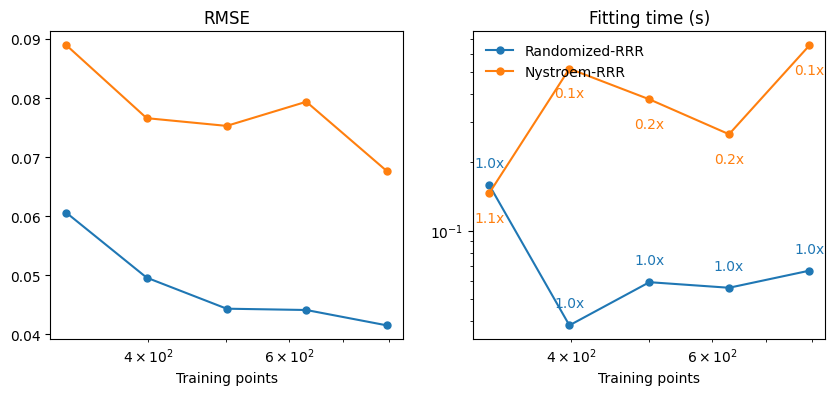

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, test_rMSE[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup[name]):
        if (name == 'Randomized-RRR'):
            c = colors[0]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup[name]):.2f}x")

